# Understanding the data

Let's start by understanding our objective and the data we have selected for this task.

In essence, a machine learning model functions similarly to a mathematical funcion that takes specific inputs and produces predictions. Instead of coding complex rules manually, we train the model using numerous examples, allowing it to learn the patterns. During training, we provide it with correct answers, or labels, ƒor each input, which are crucial for its learning process. Each training instance comprises a pair consisting of inputs and their corresponding labels.

For this project, we aim to develop a straightforward model for land cover classification, using the [Dynamic World](https://dynamicworld.app/) dataset. The DwLCDB is a collection of land cover maps that represent the Earth's surface at a 30m resolution. Each pixel in the map is assigned a specific land cover class, such as forest, water, or urban area. The dataset contains several features, such as the spectral bands of the pixels, the land cover class, and the quality of the classification. Land cover data is vital across various fields, including climate research, energy, water, management, agriculture, conservation, and more. The framework we develop for this model can be adapted for many other similar tasks.

# Earth Engine Basics

[Google Earth Engine](https://earthengine.google.com/) is a cloud-based platform that allows users to access a vast amount of geospatial data and perform complex analyses. It provides a wide range of datasets, including satellite imagery, climate data, and land cover maps. Earth Engine also offers a JavaScript API that enables users to interact with the platform and perform various geospatial tasks. It amalgamates petabytes of geospatial data and offers a suite of functions for its processing and analysis. We'll be utilizing the Earth Engine Python client library for our tasks, although you can explore different methods of interfacing with Earth Engine by checking the [API Reference](https://developers.google.com/earth-engine/apidocs) page.

Here are some fundamental concepts in Earth Engine:

- Band: A band is essentially a matrix, containing pixel values. Each pixel within a band holds a single numeric value, which can be in various forms such as bytes, integers, or floats.
- [Image](https://developers.google.com/earth-engine/guides/image_overview): Images in Earth Engine consist of one or more bands, each identified by a unique name.
- [ImageCollection](https://developers.google.com/earth-engine/guides/ic_creating): This refers to a set of images, functioning similarly to a list, containing zero or more images.
- [Geometry](https://developers.google.com/earth-engine/guides/geometries): This typically refers to geospatial data points, which can be a single point coordinate, a polygon, or a multi-polygon.
- [Feature](https://developers.google.com/earth-engine/guides/features): A feature in Earth Engine includes a Geometry paired with a value.
- [FeatureCollection](https://developers.google.com/earth-engine/guides/feature_collections): Similar to ImageCollection, this is a compilation of zero or more features, comparable to a list of features.
- [Scale](https://developers.google.com/earth-engine/guides/scale): This term describes the pixel resolution of an image, which is measured in meters.

In [2]:
from datetime import datetime, timedelta
import folium
import ee

import io

from google.api_core import exceptions, retry
import google.auth
import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured
import requests
import geemap

/Users/ani/Desktop/Anirudh/Big Data/big_data_project/big-data/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
WINDOW = timedelta(days=1)
LAND_COVER_DATASET = "GOOGLE/DYNAMICWORLD/V1"  # Dynamic World Land Cover dataset


In [4]:
project = "ee-anirudhananth"
# Use cli to authenticate
# !earthengine authenticate

# Or use the following code to authenticate
def initialize_ee():
  ee.Authenticate()
  ee.Initialize(project=project, opt_url="https://earthengine-highvolume.googleapis.com")

In [5]:
initialize_ee()

In [6]:
# from IPython.core.display import display, HTML
# display(HTML("""
# <style>
#     .output {
#         display: flex;
#         align-items: center;
#         justify-content: center;
#     }
#     .output_area {
#         width: 100% !important;
#         height: 100% !important;
#         display: flex;
#     }
#     .output_area img, .output_area iframe {
#         width: 100% !important;
#         height: 100% !important;
#     }
# </style>
# """))


In [7]:
import ee
import geemap

# Initialize the Earth Engine module.
ee.Initialize()

# Define your location and time range

date = datetime(2022, 4, 1, 18)
location = ee.Geometry.Point(-73.968285, 40.785091)
window_start = (date - WINDOW).isoformat()
window_end = date.isoformat()

# Apply filters for location and date
col_filter = ee.Filter.And(
    ee.Filter.bounds(location),
    ee.Filter.date('2021-01-01', '2021-12-31'),
)

# Load Dynamic World collection
dw_col = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(col_filter)

# Check if collection is empty
if dw_col.size().getInfo() == 0:
    print("No images found for given date and location.")
else:
    # Take the first image from the collection
    dw_image = ee.Image(dw_col.first())

    # Display the Dynamic World image
    m = geemap.Map()
    m.set_center(-73.968285, 40.785091, 12)
    m.addLayer(dw_image, {}, 'Dynamic World Image')
    m


In [8]:
def get_gpm(date: datetime) -> ee.Image:
    """Get a GPM image for the given date."""
    window_start = (date - WINDOW).isoformat()
    window_end = date.isoformat()
    return (
        ee.ImageCollection(LAND_COVER_DATASET)
        .filterDate(window_start, window_end)
        # .select("*")
        .sort("system:time_start", False)
        .median()
        .unmask(0)
        .float()
    )

def get_gpm_sequence(dates: list[datetime]) -> ee.Image:
    """Get a sequence of GPM images for the given dates."""
    images = [get_gpm(date) for date in dates]
    return ee.ImageCollection(images).toBands()

def mask_sentinel2_clouds(image: ee.Image) -> ee.Image:
    CLOUD_BIT = 10
    CIRRUS_CLOUD_BIT = 11
    bit_mask = (1 << CLOUD_BIT) | (1 << CIRRUS_CLOUD_BIT)
    mask = image.select("QA60").bitwiseAnd(bit_mask).eq(0)
    return image.updateMask(mask)

def get_input_image(year: int, default_value: float = 1000.0) -> ee.Image:
    return (
        ee.ImageCollection("COPERNICUS/S2_HARMONIZED")  # Sentinel-2 images
        .filterDate(f"{year}-1-1", f"{year}-12-31")  # filter by year
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))  # filter cloudy images
        .map(mask_sentinel2_clouds)  # mask/hide cloudy pixels
        .select("B.*")  # select all bands starting with B
        .median()  # median of all non-cloudy pixels
        .unmask(default_value)  # default value for masked pixels
        .float()  # convert to float32
    )

In [20]:
import folium

image = get_input_image(2021)
vis_params = {
    "min": 0,
    "max": 3000,
    "bands": ["B4", "B3", "B2"],
}
folium.Map(
    location=(40.785091, -73.968285),
    zoom_start=9,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    scrollWheelZoom=False,
    dragging=False
)

In [21]:
image = get_input_image(2021)
vis_params = {
    "min": 0,
    "max": 3000,
    "bands": ["B4", "B3", "B2"],
}
folium.Map(
    location=(40.785091, -73.968285),
    zoom_start=12,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    scrollWheelZoom=False,
    dragging=False
)

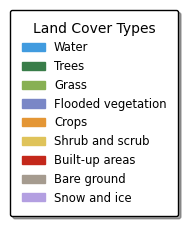

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Define your classes and their corresponding colors
class_names = [
    'Water', 'Trees', 'Grass', 'Flooded vegetation',
    'Crops', 'Shrub and scrub', 'Built-up areas', 'Bare ground', 'Snow and ice'
]
colors = [
    '#419bdf', '#397d49', '#88b053', '#7a87c6',
    '#e49635', '#dfc35a', '#c4281b', '#a59b8f', '#b39fe1'
]

# Create a list of patches for the legend
patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]

# Create the legend
plt.figure(figsize=(0, 0))
plt.legend(handles=patches, loc='center', title='Land Cover Types', fontsize='small', shadow=True, fancybox=True, facecolor='white', edgecolor='black', borderpad=1)
plt.axis('off')  # Turn off the axis
plt.show()


In [15]:
import ee
import folium

# Initialize the Earth Engine module.
ee.Initialize()

def get_dynamic_world_image() -> ee.Image:
    # Load the Dynamic World dataset
    image = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")\
                .filter(ee.Filter.date('2021-01-01', '2021-12-31'))\
                .select('label')\
                .mode()\
                .rename('landcover')

    return image.byte()  # ensure the data type is byte for visualization

# Generate a folium map
def generate_map(location, zoom_start=9, width="100%", height="100%") -> folium.Map:
    # location = [40.785091, -73.968285]  # Example coordinates, adjust as needed
    
    # Set visualization parameters based on Dynamic World classifications
    vis_params = {
        'bands': ['landcover'],
        'min': 0,
        'max': 8,
        'palette': [
            '419BDF',    # Water
            '397D49',    # Trees
            '88B053',    # Grass
            'E1C340',    # Flooded Vegetation
            'DC9A26',    # Crops
            'C44A22',    # Scrub/Shrub
            'A16943',    # Built Area
            'B39FE1',    # Bare Ground
            '6F6F6F'     # Snow/Ice
        ]
    }
    my_map = folium.Map(
        location=location, 
        zoom_start=zoom_start, 
        width=width, 
        height=height, 
        scrollWheelZoom=False,
        dragging=False
    )

    image = get_dynamic_world_image()

    # Add the Earth Engine layer to the folium map
    my_map.add_ee_layer(image, vis_params, 'Dynamic World')

    return my_map

# Add EE drawing method to folium.Map.
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [16]:
# Generate and display the map
my_map = generate_map([40.785091, -73.968285], 9, '100%', '100%')
my_map.add_child(folium.LayerControl())
my_map

In [17]:
# Generate and display the map
my_map = generate_map([40.785091, -73.968285], 12, '100%', '100%')
my_map.add_child(folium.LayerControl())
my_map